# 0. Install and Import Dependencies

In [1]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      2.0.0
aiofiles                     22.1.0
aiosqlite                    0.18.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        22.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
boltons                      23.0.0
brotlipy                     0.7.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           2.0.4
colorama                     0.4.6
comm                         0.1.2
conda                        23.7.2
conda-content-trust          0.1.3
conda-libmamba-solver        23.5.0
conda-package-handling       2.1.0
conda_package_streaming      0.8.0

In [61]:
import sys

print(sys.version_info)
!python --version

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Python 3.11.4


In [2]:
!pip install opencv-python==4.6.0.66
!pip install matplotlib==3.6.2
!pip install imageio==2.23.0
!pip install tensorflow==2.10.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.10.1


In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [7]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=949d50f6-fb0a-4d65-a130-4cd02b305227
To: C:\Users\DELL\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [02:45<00:00, 2.55MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [13]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [14]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [15]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [16]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [17]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [18]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [19]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [20]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

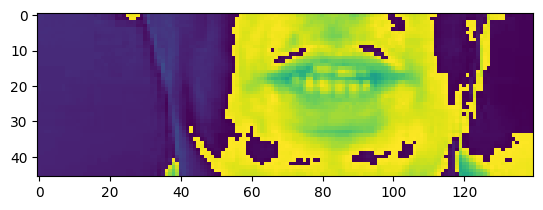

In [21]:
plt.imshow(frames[40])

In [22]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [23]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [24]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [36]:
from matplotlib import pyplot as plt

In [37]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [38]:
len(test)

50

In [39]:
frames, alignments = data.as_numpy_iterator().next()

In [40]:
len(frames)

2

In [41]:
sample = data.as_numpy_iterator()

In [42]:
val = sample.next(); val[0]

array([[[[[ 1.4386014 ],
          [ 1.4386014 ],
          [ 1.4764593 ],
          ...,
          [ 9.426624  ],
          [ 0.15143172],
          [ 0.22714758]],

         [[ 1.4386014 ],
          [ 1.4386014 ],
          [ 1.4764593 ],
          ...,
          [ 9.50234   ],
          [ 9.653772  ],
          [ 0.15143172]],

         [[ 1.4007434 ],
          [ 1.4007434 ],
          [ 1.3628855 ],
          ...,
          [ 0.07571586],
          [ 0.22714758],
          [ 0.22714758]],

         ...,

         [[ 0.94644827],
          [ 0.94644827],
          [ 0.94644827],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.94644827],
          [ 0.94644827],
          [ 0.94644827],
          ...,
          [ 9.653772  ],
          [ 9.653772  ],
          [ 9.653772  ]],

         [[ 0.94644827],
          [ 0.94644827],
          [ 0.94644827],
          ...,
          [ 9.653772  ],
          [ 9.653772  ],
          

In [31]:
!pip install imageio==2.23.0

In [43]:
imageio.mimsave('./animation.gif', val[0][1], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 10.463469505310059]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.463469505310059]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.463469505310059]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.463469505310059]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.463469505310059]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.463469505310059]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.463469505310059]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

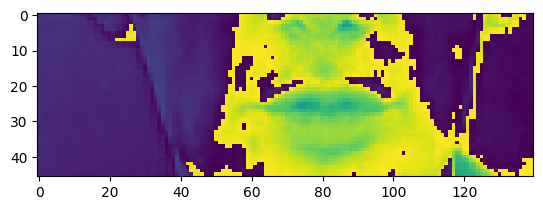

In [44]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [45]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white in o two please'>

# 3. Design the Deep Neural Network

# 4. Setup Training Options and Train

# 5. Make a Prediction 

# Test on a Video